In [1]:
import os
import cv2
import time
import uuid
import matplotlib.pyplot as plt

# Collecting Data

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

# I am taking 30 images at a time, and I have run this code for 3 times.
# So, there are total of 90 images
# Then, I partitioned the data into 3 parts : Train, test and validation

In [6]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(2)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# Creating Labels for those 90 images

In [7]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\aksha\.labelmerc


# Creating tensors for images and labels

In [8]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [9]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [10]:
images.as_numpy_iterator().next()

b'data\\images\\a8f43673-b8ea-11ee-b2c8-48684a813d2c.jpg'

In [11]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
images = images.map(load_image)

In [13]:
image_generator = images.batch(4).as_numpy_iterator()

In [14]:
plot_images = image_generator.next()

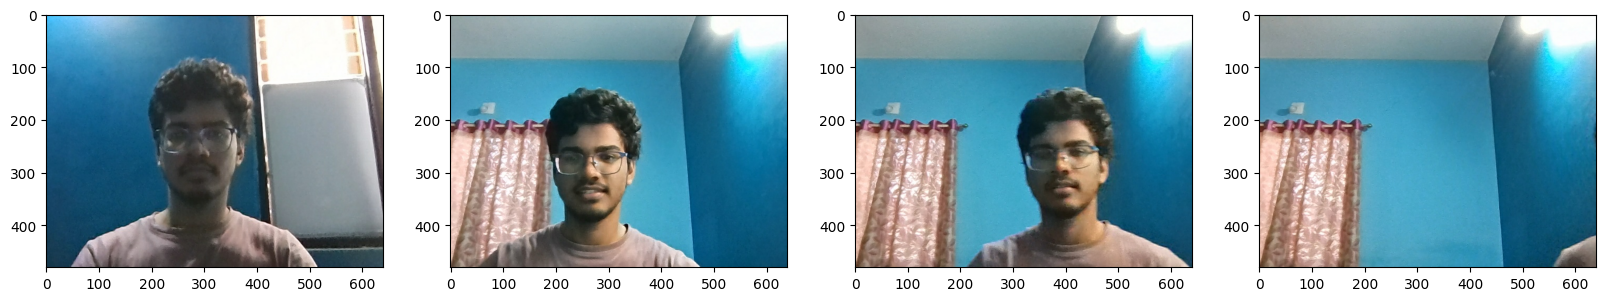

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [16]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# Data Augmentation Pipeline

In [17]:
import albumentations as alb

In [18]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

# Visualising the Augmented image with bounding box

In [21]:
img = cv2.imread(os.path.join('data','train', 'images','0bd2648e-b8ea-11ee-8d63-48684a813d2c.jpg'))

In [22]:
with open(os.path.join('data', 'train', 'labels', '0bd2648e-b8ea-11ee-8d63-48684a813d2c.json'), 'r') as f:
    label = json.load(f)

In [23]:
label['shapes'][0]['points']

[[94.57627118644066, 202.71186440677965],
 [236.38418079096044, 399.3220338983051]]

In [24]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [25]:
img.shape

(480, 640, 3)

In [26]:
coords

[94.57627118644066, 202.71186440677965, 236.38418079096044, 399.3220338983051]

In [27]:
coords = list(np.divide(coords, [640,480,640,480]))

In [28]:
coords

[0.14777542372881353,
 0.4223163841807909,
 0.3693502824858757,
 0.8319209039548023]

In [29]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [30]:
augmented['bboxes'][0][2:]

(0.9787193973634651, 0.5606403013182675)

In [31]:
augmented['bboxes']

[(0.6635907093534212,
  0.12372881355932197,
  0.9787193973634651,
  0.5606403013182675)]

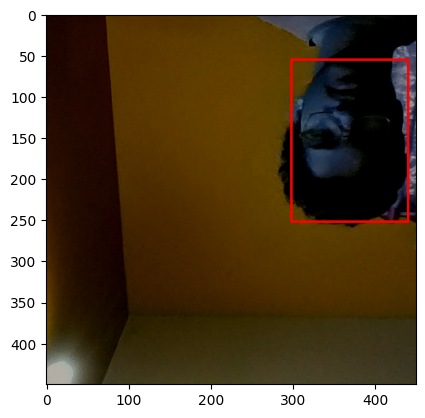

In [32]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# Applying the Augmentation pipeline to our data

In [34]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

# Finally, loading the augmented images to tensors

In [35]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [36]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [37]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

# Loading the labels to tensors

In [38]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [39]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [40]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

# Combining the Data

In [43]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [44]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [45]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [51]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.      , 0.01942 , 0.1803  , 0.4626  ],
        [0.4756  , 0.1554  , 0.9844  , 0.8223  ],
        [0.      , 0.1798  , 0.2091  , 0.6104  ],
        [0.003452, 0.196   , 0.429   , 0.7446  ],
        [0.      , 0.344   , 0.4329  , 0.9883  ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.04822 , 0.1017  , 0.5166  , 0.806   ],
        [0.352   , 0.086   , 0.7173  , 0.547   ]], dtype=float16))

# Visualising the data

In [113]:
data_samples = train.as_numpy_iterator()

In [114]:
res = data_samples.next()

In [101]:
coords = res[1][1][0]
img = res[0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


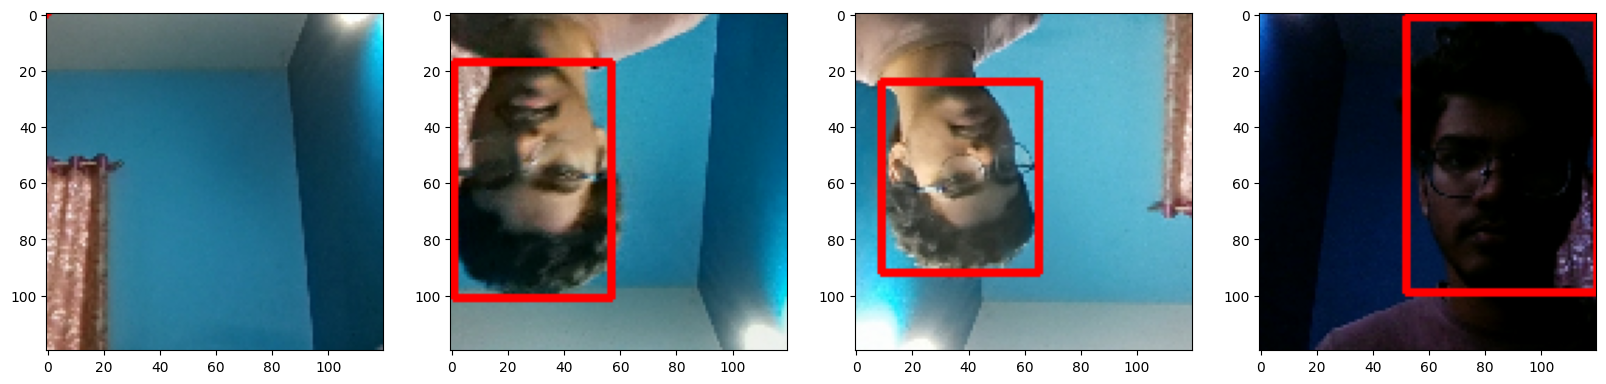

In [116]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    sample_image = sample_image.copy()
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Using a pre-created state of the art model, VGG and finetuning the model to our data

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [56]:
vgg = VGG16(include_top=False)

In [57]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# Building our custom model over VGG

In [58]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [59]:
facetracker = build_model()

In [60]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [61]:
X, y = train.as_numpy_iterator().next()

In [62]:
X.shape

(8, 120, 120, 3)

In [63]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 628ms/step


In [64]:
classes, coords

(array([[0.49977702],
        [0.4267763 ],
        [0.49644756],
        [0.46558812],
        [0.57206017],
        [0.5400299 ],
        [0.5006928 ],
        [0.52966607]], dtype=float32),
 array([[0.33529818, 0.5240233 , 0.3798038 , 0.38584352],
        [0.36405727, 0.589825  , 0.45755628, 0.29138854],
        [0.37718335, 0.5442574 , 0.38750762, 0.29244795],
        [0.41930613, 0.5168581 , 0.47144648, 0.312108  ],
        [0.38042665, 0.54644054, 0.38953996, 0.25890595],
        [0.42415538, 0.47361037, 0.43506238, 0.33467042],
        [0.38323316, 0.618928  , 0.4342371 , 0.3812286 ],
        [0.403771  , 0.5347073 , 0.4217879 , 0.4198275 ]], dtype=float32))

In [65]:
batches_per_epoch = len(train)

In [66]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [67]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [68]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [69]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.354728>

In [70]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6889664>

In [71]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.354728>

In [72]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [73]:
model = FaceTracker(facetracker)

In [74]:
model.compile(opt, classloss, regressloss)

In [75]:
logdir='logs'

In [76]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [79]:
hist = model.fit(train, epochs=25, callbacks=[tensorboard_callback])

Epoch 1/25
473/473 [==============================] - 410s 860ms/step - total_loss: 0.2124 - class_loss: 0.0638 - regress_loss: 0.1805
Epoch 2/25
473/473 [==============================] - 469s 987ms/step - total_loss: 0.1460 - class_loss: 0.0448 - regress_loss: 0.1236
Epoch 3/25
473/473 [==============================] - 476s 999ms/step - total_loss: 0.1235 - class_loss: 0.0399 - regress_loss: 0.1036
Epoch 4/25
473/473 [==============================] - 486s 1s/step - total_loss: 0.0879 - class_loss: 0.0328 - regress_loss: 0.0715
Epoch 5/25
473/473 [==============================] - 457s 960ms/step - total_loss: 0.0893 - class_loss: 0.0325 - regress_loss: 0.0730
Epoch 6/25
473/473 [==============================] - 448s 941ms/step - total_loss: 0.0603 - class_loss: 0.0215 - regress_loss: 0.0495
Epoch 7/25
473/473 [==============================] - 490s 1s/step - total_loss: 0.1268 - class_loss: 0.0388 - regress_loss: 0.1074
Epoch 8/25
473/473 [==============================] - 457s 95

KeyboardInterrupt: 

In [103]:
facetracker.save('facetracker.h5')

In [80]:
hist.history

NameError: name 'hist' is not defined

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [81]:
test_data = test.as_numpy_iterator()

In [151]:
test_sample = test_data.next()

In [152]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 301ms/step


In [153]:
yhat

[array([[0.9993009 ],
        [0.9999989 ],
        [0.99965006],
        [0.00632713],
        [0.00288998],
        [0.99656683],
        [0.99998367],
        [0.9999807 ]], dtype=float32),
 array([[0.41969556, 0.13819236, 0.8393398 , 0.7932913 ],
        [0.40153518, 0.20549268, 0.87019086, 0.8239843 ],
        [0.3568338 , 0.02042985, 0.8351199 , 0.42054543],
        [0.00435333, 0.00402223, 0.00613386, 0.00767519],
        [0.00236057, 0.002853  , 0.00354865, 0.00538066],
        [0.19854078, 0.15751864, 0.63198507, 0.7573097 ],
        [0.17766741, 0.24706683, 0.6557903 , 0.86632305],
        [0.20668004, 0.24160759, 0.6791721 , 0.8537544 ]], dtype=float32)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


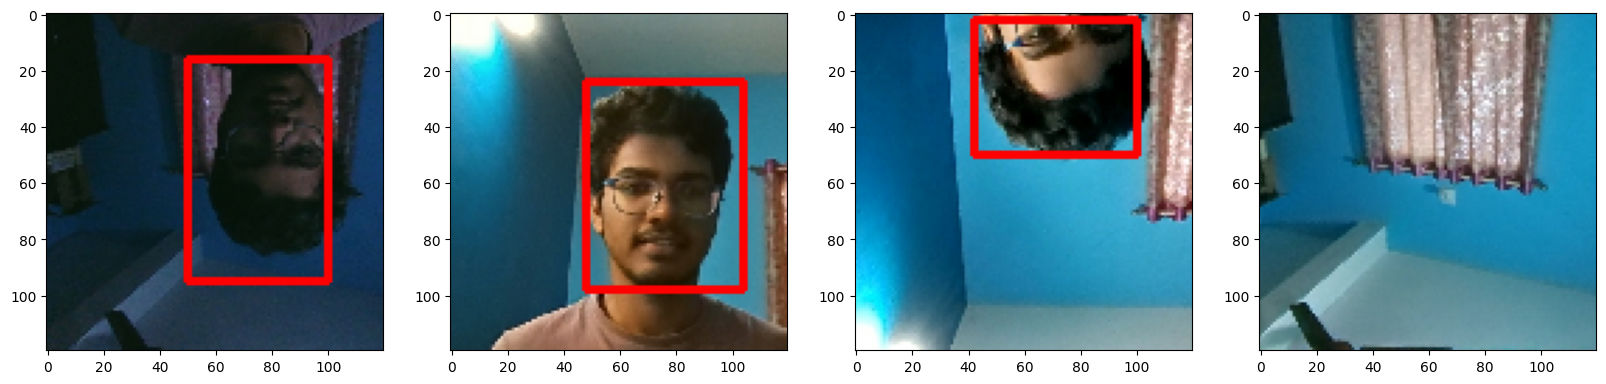

In [154]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    sample_image = sample_image.copy()
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [156]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 67ms/step
